<font style='color:red'>CH9. Transformers</font>
- 인코더 층만으로 구현(입력:자연어, 출력:긍정/부정)

## 1. 패키지

In [1]:

import numpy as np
from keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Dropout, GRU

from sklearn.metrics import confusion_matrix, f1_score, precision_score,recall_score

c:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## 2. 하이퍼 파라미터 설정(이 파라미터를 바꾸면 정확도나 학습 속도에 차이남)

In [2]:
MY_WORDS = 10000 # imdb 데이터의 단어수
MY_LENGTH = 80   # 영화평 단어수 80개만 독립변수
MY_EMBED = 32    # Embedding layer의 결과 차원
MY_HIDDEN = 64   # LSTM의 유닛수

MY_EPOCH = 10    # 학습 수
MY_BATCH = 200   # batch_size (fit이 매번 데이터를 가져오는 값)

## 3. 데티어불러오기

In [3]:

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MY_WORDS)

## 4. 문자단어 -> 정수

In [4]:
word_to_id = imdb.get_word_index() # {'word':id}
id_to_word = {}
for word, value in word_to_id.items():
    id_to_word[value] = word

In [5]:
msg = 'What a wonderful movie'
msg = msg.lower().split()
# 1: 리뷰시작을 알리는 숫자, 2: 문자가 짤려서 잘못읽어옴, 3: padding 처리
data = [1] + [word_to_id.get(m,-1)+3 for m in msg]

## 5. 숫자영화평 -> 자연어 영화평 return 함수

In [6]:
def decoding(review_num):
    decoded = [id_to_word.get(num-3, '???') for num in review_num]
    return ' '.join(decoded)

## 6. 영화평 (독립변수)의 길이

In [7]:
def show_length(x_train):
    print('첫 20개 영화평 길이')
    print([len(x_data) for x_data in x_train[:20]])

## 7. 모든 영화평 길이를 동일하게(80)

In [8]:
X_train = pad_sequences(x_train, padding='pre',truncating='pre',maxlen=MY_LENGTH)
X_test = pad_sequences(x_test, padding='pre',truncating='pre',maxlen=MY_LENGTH)
show_length(X_train), show_length(X_test)

첫 20개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
첫 20개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]


(None, None)

## 8. 최종 데이터 shape 확인

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 80), (25000,), (25000, 80), (25000,))

## 9. 모델 생성(LSTM)

In [33]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS,     # 10000
                    output_dim=MY_EMBED,    # 32
                    input_length=MY_LENGTH))# 80
# RNN : 입력 단어의 길이 수가 너무 길면 파라미터 업데이트 안 됨
# 개선모델1 . LSTM 개선모델2. GRU
model.add(Dropout(0.4))
model.add(GRU(units=MY_HIDDEN,
               input_shape=(MY_LENGTH,MY_EMBED)))

model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 32)            320000    
                                                                 
 dropout_1 (Dropout)         (None, 80, 32)            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                18816     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 338,881
Trainable params: 338,881
Non-trainable params: 0
_________________________________________________________________


## 9. 모델 생성(Transformers)

In [10]:
import tensorflow as tf
from keras import layers
from keras.models import Sequential, Model
INPUTS = layers.Input(shape=(MY_LENGTH,)) # 80
INPUT_EMBEDDING = layers.Embedding(input_dim=MY_WORDS, # 10000
output_dim=MY_EMBED)(INPUTS)# 32

# Positional Encoding
POSITIONS = tf.range(start=0,
limit=MY_LENGTH)
POS_ENCODING = layers.Embedding(input_dim=MY_LENGTH, output_dim=MY_EMBED)(POSITIONS)
POS_ENC_OUTPUT = POS_ENCODING + INPUT_EMBEDDING
ATTENTION_OUTPUT = layers.MultiHeadAttention(num_heads=3,
key_dim=MY_EMBED)(POS_ENC_OUTPUT,
POS_ENC_OUTPUT)
X = layers.add([POS_ENC_OUTPUT, ATTENTION_OUTPUT])
X = layers.BatchNormalization()(X)

# FeedForward Network
FFN = Sequential([layers.Dense(MY_HIDDEN, activation="relu"),
layers.Dense(MY_EMBED, activation="relu")])(X)
X = layers.add([FFN, X])
X = layers.BatchNormalization()(X)

# 하나의 벡터로 압축해서 Dense로 보내줌
X = layers.GlobalAveragePooling1D()(X)
X = layers.Dropout(0.1)(X)
X = layers.Dense(MY_HIDDEN, activation="relu")(X)
X = layers.Dropout(0.1)(X)
OUTPUTS = layers.Dense(2, activation="softmax")(X)
model = Model(inputs=INPUTS, outputs=OUTPUTS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 32)       320000      ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 80, 32)      0           ['embedding[0][0]']              
 da)                                                                                              
                                                                                                  
 multi_head_attention (MultiHea  (None, 80, 32)      12608       ['tf.__operators__.add[0][0]'

## 10. 학습환경 설정 및 학습하기

In [12]:
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

hist = model.fit(X_train, y_train, epochs=5, batch_size=MY_BATCH, validation_split=0.2)

Epoch 1/5
100/100 [==============================] - 17s 162ms/step - loss: 0.4671 - acc: 0.7728 - val_loss: 0.6214 - val_acc: 0.6394
Epoch 2/5
100/100 [==============================] - 16s 162ms/step - loss: 0.2800 - acc: 0.8846 - val_loss: 0.5604 - val_acc: 0.7724
Epoch 3/5
100/100 [==============================] - 16s 160ms/step - loss: 0.2191 - acc: 0.9135 - val_loss: 0.5003 - val_acc: 0.7768
Epoch 4/5
100/100 [==============================] - 16s 163ms/step - loss: 0.1774 - acc: 0.9298 - val_loss: 0.4193 - val_acc: 0.8144
Epoch 5/5
100/100 [==============================] - 17s 165ms/step - loss: 0.1412 - acc: 0.9406 - val_loss: 0.5307 - val_acc: 0.8022


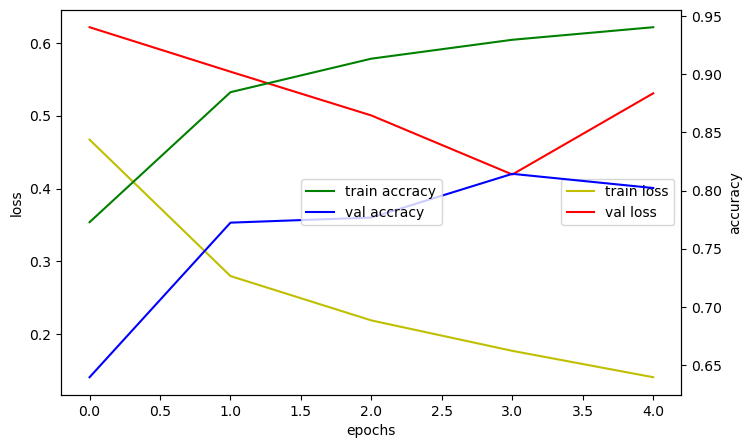

In [13]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(8,5))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax =loss_ax.twinx()
acc_ax.plot(hist.history['acc'], 'g', label='train accracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val accracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc = 'center right')
acc_ax.legend(loc = 'center')


# 11. 모델 평가하기

In [122]:
# 혼동행렬, recall, precision을 위한 yhat
y_hat = (model.predict(X_test)>0.5).astype(np.int16)
print(y_hat.reshape(-1))

782/782 [==============================] - 10s 13ms/step
[0 1 1 ... 0 0 1]


In [124]:
# 혼동행렬
confusion_matrix(y_test, y_hat)

array([[10246,  2254],
       [ 2579,  9921]], dtype=int64)

In [ ]:
# recall (실제 True인 것 중 True로 예측한 비율)
recall_score(y_test, y_hat)


0.79368

In [126]:
# precisioin(True로 예측한 것 중 실제값을 False로 예측한 비율)
precision_score(y_test, y_hat)

0.8148665297741273

In [3]:
model = load_model('data/영화감정평가.h5')

# 11.모델 사용

In [36]:
import re
review = 'The movie was so boring that I slept the whole time watching it'.lower()
review = re.sub('[^a-zA-Z\'\s]', ' ', review)
print('영화평(특수문자 제외) :',review)
review = review.split()
review = [1] + [word_to_id.get(word,-1)+3 for word in review]

영화평(특수문자 제외) : the movie was so boring that i slept the whole time watching it


In [37]:
input_data = pad_sequences([review], padding='pre',truncating='pre',maxlen=MY_LENGTH)

In [ ]:
result = model.predict(input_data > 0.5).astype('int8').reshape(-1)[0]
result

1/1 [==============================] - 0s 361ms/step


0